# Meta-data

In [263]:
#OS libs
import os
import sys
from pathlib import Path
from io import StringIO
#Data handling libs
import pandas as pd
from tqdm import tqdm
from chess.pgn import read_game, BaseVisitor
import chess.engine
#Data visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MultipleLocator, FuncFormatter, LogLocator
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patches as mplp

#Meta-data
dt_pred_folder = os.path.join(os.getcwd(),'dt_chess','datasets_test_predictions')
state_emb_type = 'linear'
predictions = os.listdir(dt_pred_folder)
predictions = [x for x in predictions if x.partition('_')[0] == state_emb_type]

# Filter prediction files

In [262]:
def filter_by(files, num_users = 0, user = 0):
    if num_users:
        filtered_files = [x for x in files if int(x.split('_')[1]) == num_users]
        # Sort ascending
        filtered_files.sort(key=lambda x: int(x.split('_')[2]),
                                  reverse=True)
        return filtered_files
    elif user:
        filtered_files = [x for x  in files if int(x.split('_')[2]) == user]
        # Sort ascending
        filtered_files.sort(key=lambda x: int(x.split('_')[1]))
        return filtered_files
    else:
        raise ValueError()
#first_user = filter_by(predictions, user=400)

# First model/user analysis

In [212]:
first_user = filter_by(predictions, user=400)
mu_1 = first_user[0]
mu_1

'linear_1_400_Jiyarkhan.csv'

## Accuracy

In [187]:
pred_df = pd.read_csv(os.path.join(dt_pred_folder,
                                   mu_1),
                      index_col=None)

original_total = len(pred_df)
tp1_original = len(pred_df[pred_df['move'] == pred_df['engine_move_1']])
tp2_original = len(pred_df[pred_df['move'] == pred_df['engine_move_2']])
tp3_original = len(pred_df[pred_df['move'] == pred_df['engine_move_3']])
fp_original = len(pred_df[pred_df['illegal_top_move']])
tn_original = original_total - (tp1_original + tp2_original + tp3_original)
#tn_original = pred_df[~pred_df[['engine_move_1', 'engine_move_2', 'engine_move_3']].isin(pred_df['move']).any(1)]
print(f"total: {original_total:,} tp1: {tp1_original:,} "
      f"tp2: {tp2_original:,} tp3: {tp3_original:,} "
      f"fp: {fp_original:,} tn: {tn_original:,} "
      f"tn1: {original_total-tp1_original:,} acc: {(tp1_original/original_total)*100:,f}%")

total: 150,669 tp1: 150,658 tp2: 10 tp3: 1 fp: 2 tn: 0 tn1: 11 acc: 99.992699%


tp1 - Model's number 1 choice is the correct move\
tp2 - Model's number 2 choice is the correct move\
tp3 - Model's number 3 choice is the correct move\
fp - Highest probability in prediction vector is for an illegal move\
tn - The correct move is not in the model's top 3 choices\
tn1 - The correct move is not in the model's number 1 choice\
acc - Model's accuracy

### Removing unneccesarry predictions

In [181]:
# Duplicate position-move
pred_df_mod = pred_df.drop_duplicates()
num_duplicates = original_total - len(pred_df_mod)
print(f'Number of duplicates: {num_duplicates:,}\n'
      f'Non-duplicates total: {original_total-num_duplicates:,}')

Number of duplicates: 21,051
Non-duplicates total: 129,618


In [184]:
# Common position-move with train data
# %% Train data
train_datasets = os.listdir(os.path.join(os.getcwd(),
                                         'dt_chess',
                                         'datasets'))
train_data = [x for x in train_datasets if x.partition('_')[0] == mu_1.split('_')[2]][0]
train_df = pd.read_csv(os.path.join(os.getcwd(),
                                    'dt_chess',
                                    'datasets',
                                    train_data),
                       index_col=(0))
train_df.rename(columns={'positions': 'board', 'moves': 'move'}, inplace=True)
train_df.drop_duplicates(inplace=True)
pred_df_fin = pd.merge(pred_df_mod, train_df,
                       on=["board","move"], how='left',
                       indicator='Exist')
common_total = len(pred_df_fin[pred_df_fin['Exist'] == 'both'])
pred_df_fin = pred_df_fin[pred_df_fin['Exist'] == 'left_only']
pred_df_fin.drop('Exist', inplace=True, axis=1)
print(f'Common positions with train data: {common_total:,}\n'
      f'Total predictions (unique position-moves): {len(pred_df_fin):,}')

Common positions with train data: 5,021
Total predictions (unique position-moves): 124,597


### Accuracy - unique position-moves

In [188]:
total = len(pred_df_fin)
tp1 = len(pred_df_fin[pred_df_fin['move'] == pred_df_fin['engine_move_1']])
tp2 = len(pred_df_fin[pred_df_fin['move'] == pred_df_fin['engine_move_2']])
tp3 = len(pred_df_fin[pred_df_fin['move'] == pred_df_fin['engine_move_3']])
fp = len(pred_df_fin[pred_df_fin['illegal_top_move']])
tn = original_total - (tp1_original + tp2_original + tp3_original)
#tn_original = pred_df[~pred_df[['engine_move_1', 'engine_move_2', 'engine_move_3']].isin(pred_df['move']).any(1)]
print(f"total: {total:,} tp1: {tp1:,} "
      f"tp2: {tp2:,} tp3: {tp3:,} "
      f"fp: {fp:,} tn: {tn:,} "
      f"tn1: {total-tp1:,} acc: {(tp1/total)*100:,f}%")

total: 124,597 tp1: 124,594 tp2: 2 tp3: 1 fp: 1 tn: 0 tn1: 3 acc: 99.997592%


## Train loss

In [82]:
dt_train_loss = os.path.join(os.getcwd(),'dt_chess', 'dt_chess_init_output.txt')
train_loss = []
with open(dt_train_loss, 'r', encoding='UTF-8') as f:
    for line in f:
        line = line.rstrip()
        try:
            it = int(line.split(' ')[3].rstrip(':'))
            tl = float(line.split(' ')[6].rstrip('.'))
            train_loss.append((it, tl))
        except:
            continue
train_loss = sorted(list(set(train_loss)), key=lambda tup: tup[1], reverse=True)
train_loss = list(zip(*train_loss))[1]

In [105]:
print(f"Max train loss: {max(train_loss):f}\n"
      f"Min train loss: {min(train_loss):f}")

Max train loss: 8.478810
Min train loss: 0.000010


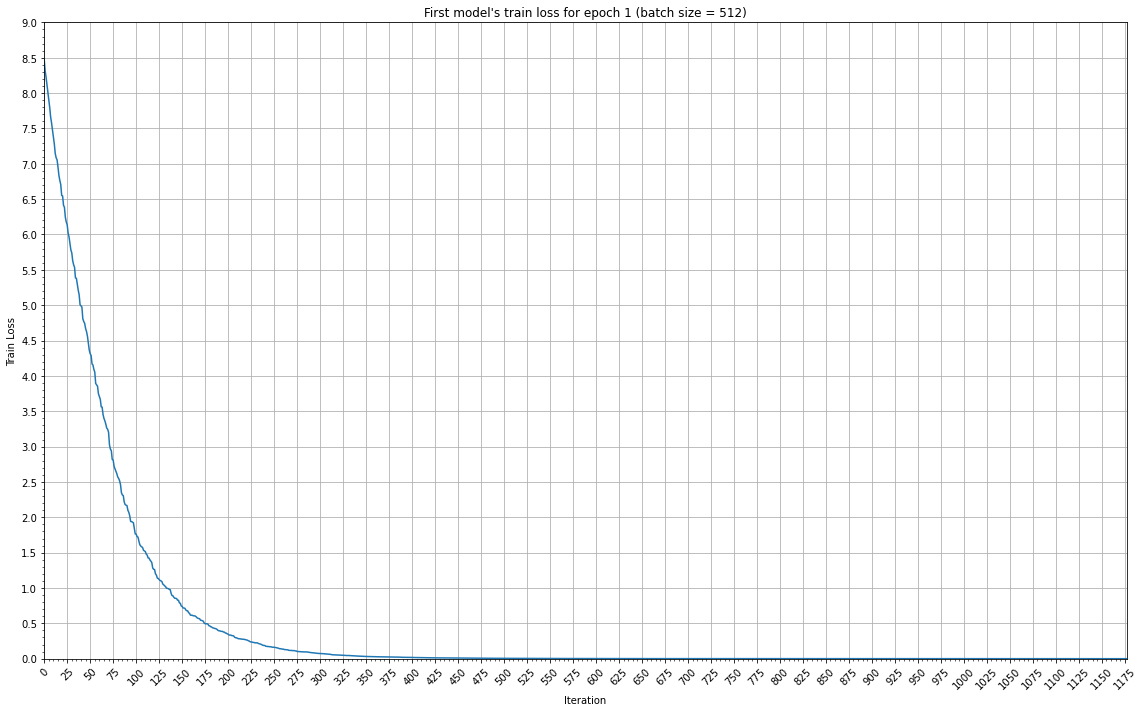

In [93]:
%matplotlib inline
def round_up(x, base=5):
    result = x + ((base - x) % base)
    # In this perticular case hard cap to 100
    # because we are working with accuracy
    if result > 100:
       result = 100
    return result

#PDF plot
plt.figure(figsize=(16, 10))
ax = sns.lineplot(data = train_loss)
ax.set(xlabel='Iteration')
ax.set(ylabel='Train Loss')
#Set major and minor ticks
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(axis='y', which='both', left=True)
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(axis='x', which='both', bottom=True)
ax.tick_params(axis="x", which="both", rotation=45)
#Extend y-limits
plt.ylim(0,round_up(max(train_loss),1))
#Tighted x-limits
plt.xlim(0,len(train_loss)-1)
#Set grid
plt.grid(visible = True, which = 'major', axis = 'y', linestyle = '-',zorder=0)
plt.grid(visible = True, which = 'major', axis = 'x', linestyle = '-',zorder=0)
plt.title(f"First model's train loss for epoch 1 (batch size = 512)")
plt.tight_layout()
plt.show()

In [113]:
print(f"Number of iterations (batches):{len(train_loss)}\n"
      f"Number of positions trained on*: {len(train_loss)*512:,}\n"
      f"First batch to reach min train loss ({min(train_loss):f}): {train_loss.index(min(train_loss))}\n"
      f"Number of positions to this batch: {train_loss.index(min(train_loss))*512:,}\n"
      f"First batch to reach train loss < 0.01: {[n for n,i in enumerate(train_loss) if i < 0.01 ][0]}\n"
      f"Number of positions to this batch:: {[n for n,i in enumerate(train_loss) if i < 0.01 ][0]*512:,}\n"
      "*Total number of position is slightly smaller because last batch is not whole")

Number of iterations (batches):1178
Number of positions trained on*: 603,136
First batch to reach min train loss (0.000010): 1094
Number of positions to this batch: 560,128
First batch to reach train loss < 0.01: 444
Number of positions to this batch:: 227,328
*Total number of position is slightly smaller because last batch is not whole


All training losses after this one are irrelevant because none go above 0.01 and all converge back to 0.00001

# First user accuracy across models

In [258]:
def unique_predictions(pred_file):
    pred_df = pd.read_csv(os.path.join(dt_pred_folder,
                                       pred_file),
                          index_col=None)
    # %% Train data
    train_datasets = os.listdir(os.path.join(os.getcwd(),
                                             'dt_chess',
                                             'datasets'))
    train_data = [x for x in train_datasets if x.partition('_')[0] == pred_file.split('_')[2]][0]
    train_df = pd.read_csv(os.path.join(os.getcwd(),
                                        'dt_chess',
                                        'datasets',
                                        train_data),
                           index_col=(0))
    train_df.rename(columns={'positions': 'board', 'moves': 'move'}, inplace=True)
    train_df.drop_duplicates(inplace=True)
    # Remove duplicates from train data
    pred_df_fin = pd.merge(pred_df, train_df,
                           on=["board","move"], how='left',
                           indicator='Exist')
    #common_total = len(pred_df_fin[pred_df_fin['Exist'] == 'both'])
    pred_df_fin = pred_df_fin[pred_df_fin['Exist'] == 'left_only']
    return pred_df_fin

def get_stats_for_predictions(pred_all_1_df):
    total = len(pred_all_1_df)
    tp1 = len(pred_all_1_df[pred_all_1_df['move'] == pred_all_1_df['engine_move_1']])
    tp2 = len(pred_all_1_df[pred_all_1_df['move'] == pred_all_1_df['engine_move_2']])
    tp3 = len(pred_all_1_df[pred_all_1_df['move'] == pred_all_1_df['engine_move_3']])
    fp = len(pred_all_1_df[pred_all_1_df['illegal_top_move']])
    tn = total - (tp1 + tp2 + tp3)
    tn1 = total - tp1
    return (total, tp1, tp2, tp3, fp, tn, tn1)

def get_stats_for_all_predictions(user_predictions, unique=True, verbose=True):
    stats = []
    pred_list = tqdm(user_predictions) if verbose else user_predictions
    for user_pred_file in pred_list:
        if unique:
            pred_df = unique_predictions(user_pred_file)
        else:
            pred_df = pd.read_csv(os.path.join(dt_pred_folder,
                                               user_pred_file),
                                  index_col=None)
        stats.append(get_stats_for_predictions(pred_df))
    return pd.DataFrame(stats, columns =["total", "tp1", "tp2", "tp3", "fp", "tn", "tn1"])
    
first_user_stats_unique_df = get_stats_for_all_predictions(first_user, unique=True)
first_user_stats_unique_df['acc'] = first_user_stats_unique_df['tp1']/first_user_stats_unique_df['total']*100
display(first_user_stats_unique_df.style.format(thousands=','))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:06<00:00,  3.14s/it]


,total,tp1,tp2,tp3,fp,tn,tn1,acc
0,"124,597","124,594",2,1,1,0,3,99.997592
1,"124,594","124,594",0,0,1,0,0,100.000000
2,"124,591","124,591",0,0,0,0,0,100.000000
3,"124,595","124,595",0,0,0,0,0,100.000000
4,"124,590","124,590",0,0,0,0,0,100.000000
5,"124,587","124,587",0,0,0,0,0,100.000000
6,"124,587","124,587",0,0,0,0,0,100.000000
7,"124,588","124,588",0,0,0,0,0,100.000000
8,"124,594","124,594",0,0,0,0,0,100.000000
9,"124,591","124,591",0,0,0,0,0,100.000000


(Complete) duplicate predictions and common datapoints with training data are removed, but we get a small variation in total number of predictions over models (Ex. A position has more than one entry and each entry has a different prediction for choices 2 and 3). Even then we still get 100% accuracy.

In [259]:
first_user_stats_df = get_stats_for_all_predictions(first_user, unique=False)
first_user_stats_df['acc'] = first_user_stats_df['tp1']/first_user_stats_df['total']*100
display(first_user_stats_df.style.format(thousands=','))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.15it/s]


,total,tp1,tp2,tp3,fp,tn,tn1,acc
0,"129,618","129,615",2,1,2,0,3,99.997686
1,"129,612","129,611",0,0,2,1,1,99.999228
2,"129,612","129,612",0,0,0,0,0,100.000000
3,"129,602","129,602",0,0,1,0,0,100.000000
4,"129,602","129,601",0,0,1,1,1,99.999228
5,"129,588","129,588",0,0,1,0,0,100.000000
6,"129,589","129,588",0,1,1,0,1,99.999228
7,"129,586","129,585",0,0,1,1,1,99.999228
8,"129,601","129,600",1,0,1,0,1,99.999228
9,"129,599","129,598",0,1,1,0,1,99.999228


Only if we consider the overlapping training data, we get very small inaccuracies (1 position gets choice 2 or 3 (tp2, tp3)).

## Other users accuracy across models

In [247]:
for user_id in range(385,400):
    curr_user = filter_by(predictions, user=user_id)
    if len(curr_user) > 1:
        username = curr_user[0].partition(str(user_id)+'_')[-1][:-len(".csv")]
        print(f"User {user_id}: {username}")
        user_stats_df = get_stats_for_all_predictions(curr_user, unique=True, verbose=False)
        user_stats_df['acc'] = user_stats_df['tp1']/user_stats_df['total']*100
        display(user_stats_df.style.format(thousands=','))

User 396: JethrofDCascalla


,total,tp1,tp2,tp3,fp,tn,tn1,acc
0,"120,073","120,070",0,0,3,3,3,99.997502
1,"120,070","120,066",1,0,11,3,4,99.996669


User 397: Lombardi


,total,tp1,tp2,tp3,fp,tn,tn1,acc
0,"125,618","125,617",0,0,4,1,1,99.999204
1,"125,618","125,618",0,0,0,0,0,100.000000
2,"125,618","125,618",0,0,1,0,0,100.000000


User 398: PaquitodeRivera


,total,tp1,tp2,tp3,fp,tn,tn1,acc
0,"96,458","96,454",2,1,3,1,4,99.995853
1,"96,460","96,455",1,0,9,4,5,99.994817
2,"96,461","96,461",0,0,0,0,0,100.000000
3,"96,460","96,460",0,0,3,0,0,100.000000


User 399: Attila-72


,total,tp1,tp2,tp3,fp,tn,tn1,acc
0,"130,594","130,590",1,0,4,3,4,99.996937
1,"130,590","130,588",1,0,2,1,2,99.998468
2,"130,584","130,584",0,0,1,0,0,100.000000
3,"130,584","130,584",0,0,0,0,0,100.000000
4,"130,584","130,584",0,0,0,0,0,100.000000


Accuracy increases and stays stable with each new user trained on the same model.

# Last user trained per model

In [264]:
last_test = []
for i in range(1,22):
    last_test.append(filter_by(predictions, num_users=i)[-1])
last_tested_df = get_stats_for_all_predictions(last_test, unique=True)
last_tested_df['acc'] = last_tested_df['tp1']/last_tested_df['total']*100
display(last_tested_df.style.format(thousands=','))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:51<00:00,  5.30s/it]


,total,tp1,tp2,tp3,fp,tn,tn1,acc
0,"124,597","124,594",2,1,1,0,3,99.997592
1,"130,594","130,590",1,0,4,3,4,99.996937
2,"96,458","96,454",2,1,3,1,4,99.995853
3,"125,618","125,617",0,0,4,1,1,99.999204
4,"120,073","120,070",0,0,3,3,3,99.997502
5,"125,159","125,159",0,0,0,0,0,100.000000
6,"111,021","111,021",0,0,0,0,0,100.000000
7,"125,778","125,778",0,0,0,0,0,100.000000
8,"108,750","108,750",0,0,0,0,0,100.000000
9,"107,516","107,516",0,0,0,0,0,100.000000
